# DE Portfolio 3: Evaluation of Logistic Regression Models

This model uses the GTD (Global Terrorism Dataset) data. The dataset includes records of terrorist incidents and events starting 1970, including details such as targets, weapons, terrorist organizations or number of kills. The goal is to predict the probability to identify the terrorist group responsible for an event given that the attack happened in Europe and North America. This will be assesed based on the output being 1 or Yes (we have a name identifying the terrorist group) and 0 or No if the name is unknown. This notebook aims to compare 3 different models (heterogeneous, homogeneous with binary values and a model with all covariates) for the same prediction goal.

Dataset Source: [https://www.start.umd.edu/gtd/](https://www.start.umd.edu/gtd/)

In [1]:
#Import Libraries 
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold

### Load and Prepare Data

In [2]:
#Read data
df=pd.read_csv('Data_All.csv')
display(df)

C:\Users\maria\AppData\Local\Temp\ipykernel_13868\3165371317.py:2: DtypeWarning: Columns (4,31,33,37,54,61,62,63,76,79,90,92,94,96,114,115,121,135) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('Data_All.csv')


,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,1_txt
0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214661,202106300023,2021,6,30,NaN,0,NaN,4,Afghanistan,6,...,"""Gunmen blow up power pylon in Parwan,"" Afghan...","""Provinces hit by blackout after power pylon d...",NaN,START Primary Collection,-9,-9,0,-9,NaN,Electricity
214662,202106300029,2021,6,30,06/30/2021,0,NaN,138,Myanmar,5,...,"""Spring Revolution Daily News for 16-30 June 2...",NaN,NaN,START Primary Collection,-9,-9,0,-9,NaN,Other Personnel
214663,202106300030,2021,6,30,NaN,1,2021-07-08,147,Nigeria,11,...,"""Boko Haram Releases Abducted Catholic Priest ...","""Kidnapped Maiduguri Catholic Priest regains f...","""ISWAP-Boko Haram Abduct Catholic Priest In Bo...",START Primary Collection,0,0,0,0,NaN,Religious Figure
214664,202106300038,2021,6,30,NaN,0,NaN,45,Colombia,3,...,"""Two dead and one wounded after clashes betwee...",NaN,NaN,START Primary Collection,0,0,0,0,NaN,NaN


#### Features selected
1. region_txt: categorical value for regions where attacks took place
    - For this model we focus on Europe and North America
2. doubtterr: Binary value, explains whether there were doubts about the attack being organized by a terrorist group (1= Doubts, 0= No doubts)
3. attacktype1_txt: categorical value defining the attack type of the event
4. targtype1_txt: (categorical value) explaining the types of targets attacked by the terrorist organisation
5. gname: The name of the terrorist organisation responsible for attack
6. weaptype1_txt: categorical value for type of weapons sued during the attack
    - For this model we focus on uclear weapons, firearms, explosives, fake weapons, incendiary weapons
6. property: If a property was attacked during the terrorist incident  (1 = Yes; 0 = No)
7. crit1: binary value explaining whether the attack had a political, social or economic goal (1=Yes; 0=No)



In [3]:
#Select relevant features
features=['region_txt',  'doubtterr', 'attacktype1_txt', 'targtype1_txt', 'gname', 'weaptype1_txt', 'crit1', 'property']
df=df[features]

#Filter dataframe so it includes only values from Europe and America
df = df[df['region_txt'].isin(['Western Europe', 'Eastern Europe', 'North America'])]

#Replace values called unknown or other with Nan and drop them
values_to_replace = ['Unknown', 'Other']
#An exception is made for terrorist group name since we need unknown values for our model
df.loc[:, df.columns != 'gname'] = df.loc[:, df.columns != 'gname'].replace(values_to_replace, pd.NA)
df=df.dropna()
display(df)

,region_txt,doubtterr,attacktype1_txt,targtype1_txt,gname,weaptype1_txt,crit1,property
3,Western Europe,0,Bombing/Explosion,Government (Diplomatic),Unknown,Explosives,1,1
5,North America,0,Armed Assault,Police,Black Nationalists,Firearms,1,1
7,North America,1,Bombing/Explosion,Utilities,Unknown,Explosives,1,1
8,North America,0,Facility/Infrastructure Attack,Military,New Year's Gang,Incendiary,1,1
9,North America,0,Facility/Infrastructure Attack,Government (General),New Year's Gang,Incendiary,1,1
...,...,...,...,...,...,...,...,...
214599,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,Incendiary,1,1
214635,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,Incendiary,1,1
214637,Western Europe,0,Facility/Infrastructure Attack,Government (General),Unknown,Incendiary,1,1
214652,North America,0,Facility/Infrastructure Attack,Religious Figures/Institutions,Unknown,Incendiary,1,1


In [4]:
#Define Y value
#If a terrorist group is known, Y is 1
Y= df['gname'].apply(lambda x:0 if x =='Unknown' else 1)

#Encode weapons
weapons=df['weaptype1_txt'].apply(lambda x:1 if x in ['Nuclear', 'Firearms', 'Explosives', 'Fake Weapons', 'Incendiary'] else 0)

#Encode attack type
attack_type=pd.get_dummies(df['attacktype1_txt'], drop_first=True)
attack_matrix = attack_type.astype(int)

#Encode target type
target_type=pd.get_dummies(df['targtype1_txt'], drop_first=True)
target_matrix=target_type.astype(int)

#Encode regions
region_type=pd.get_dummies(df['region_txt'], drop_first=True)
region_matrix = region_type.astype(int)

#Ensure numerical features are integers
doubt_attack=df['doubtterr'].astype(int)
ideology=df['crit1'].astype(int)
property=df['property'].astype(int)

#Create design matrix
X = pd.concat([doubt_attack, target_matrix, attack_matrix, ideology, property, weapons, region_matrix], axis=1)


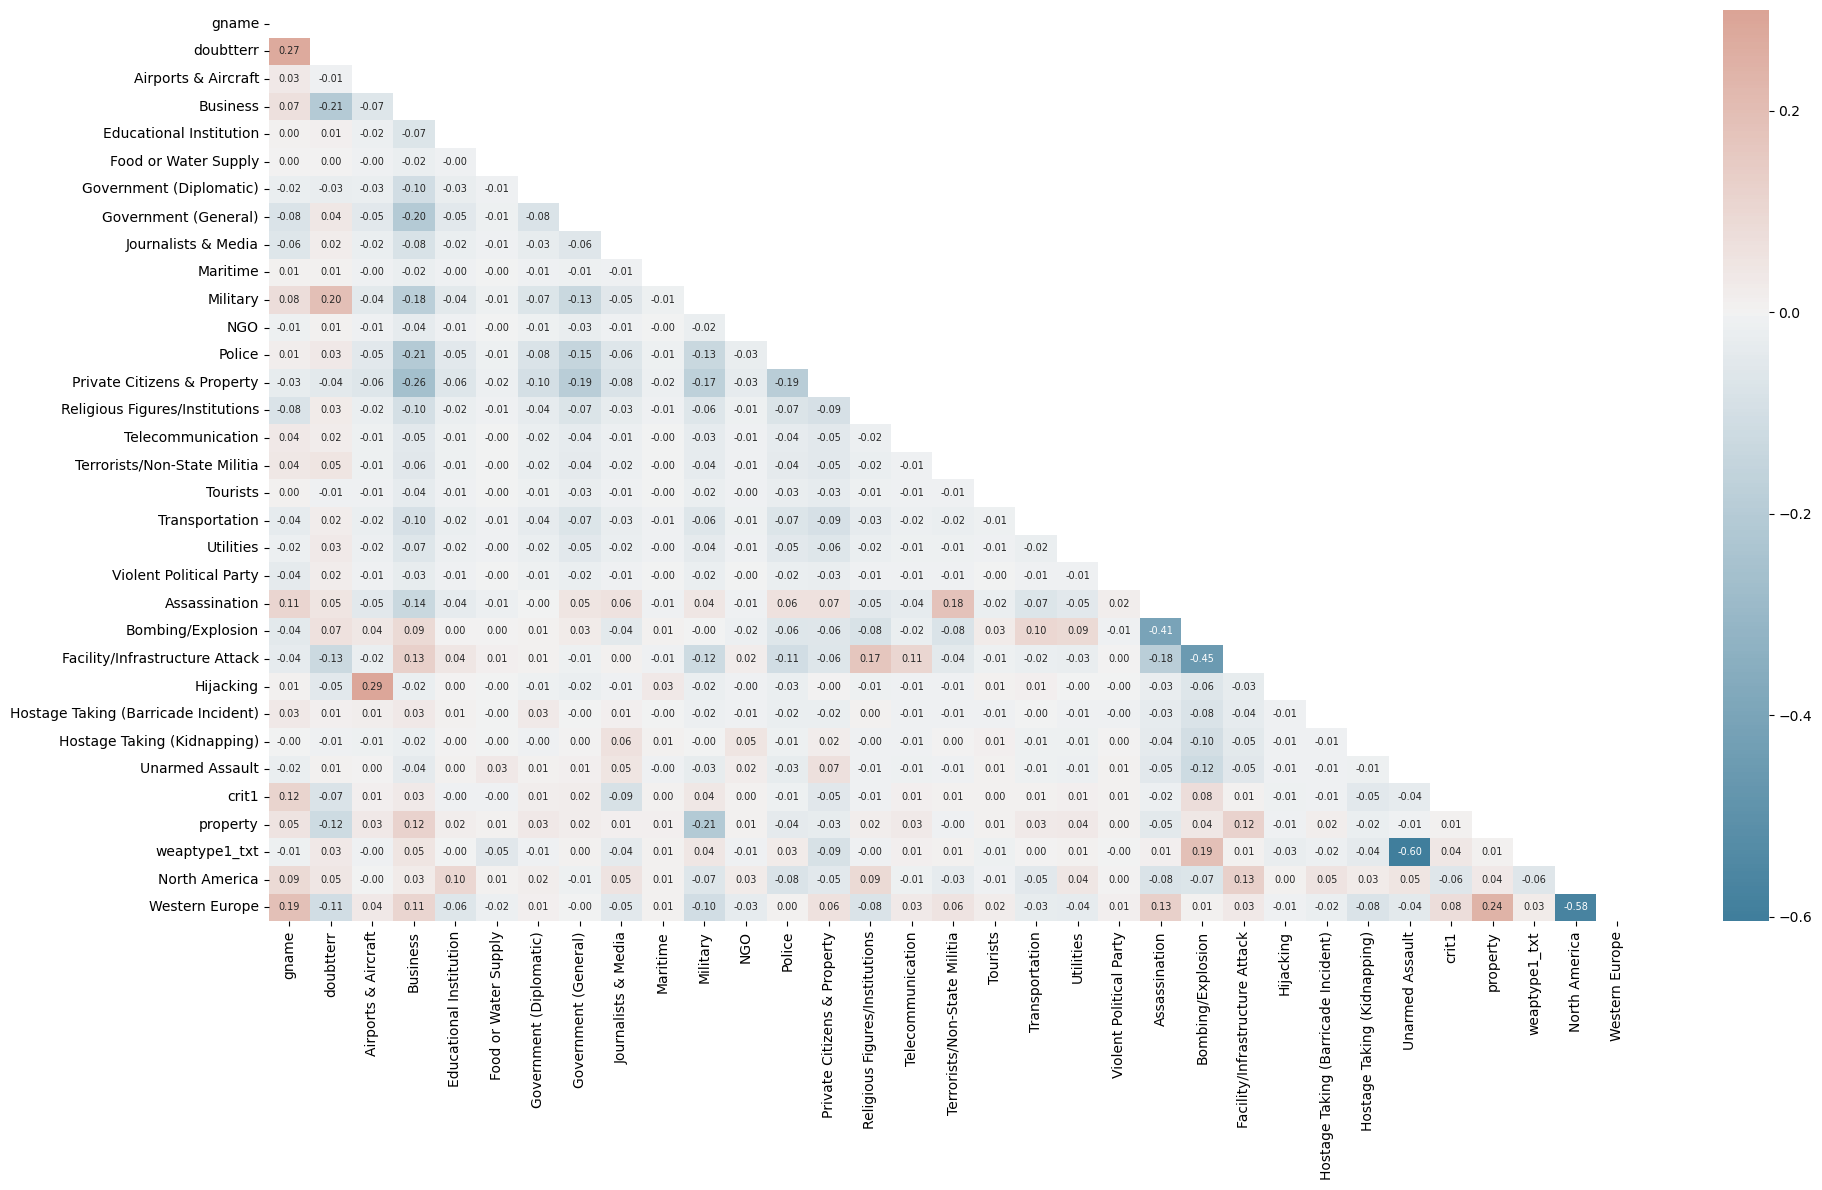

In [5]:
#Add group name to X and concat with Y to plot correlation matrix
X['gname'] = Y
YX = X[['gname'] + [c for c in X.columns if c != 'gname']]  #This puts the gname column as the first row

#Calculate the Matrix
corr = YX.corr()

#Plot
plt.figure(figsize=(20, 12))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

### Prepare data and models for K cross validation

In [6]:
#Redefine X as the desgin matrix
X = pd.concat([doubt_attack, target_matrix, attack_matrix, ideology, property, weapons, region_matrix], axis=1)

#Add intercept to design matrix
X_with_constant = sm.add_constant(X)

#Concat X and Y
YX_constant =  pd.concat([Y,X_with_constant],axis = 1)

In [7]:
#Split data into test set and validation set (proportion used is 25-test / 75-validation)

#Extract 25% of the dataset using integer division to get result as an int
samples = YX_constant.shape[0]* 25 // 100

#Create list of all row IDs assuming they start at 0
row_id = list(range(YX_constant.shape[0]))

#Select 25% of IDs randomly
row_ids = random.sample(row_id, samples)

#Create test set
YX_test = YX_constant.iloc[YX_constant.index.isin(row_ids)] # the randomly chosen 25% goes to test-set

#Create validation set
YX_validation = YX_constant.iloc[~YX_constant.index.isin(row_ids)] # the remaining 75% is our validation set

In [8]:
#Define predictor features for each model

#Select categorical values that have to be dropped for model B
cols=set().union(region_matrix.columns, target_matrix.columns, attack_matrix.columns)
predictors = {
    'A': ['const'], #model with just the constant
    'B': [col for col in X_with_constant.columns if col not in cols], #model with binary values
    'C': X_with_constant.columns.tolist() #model with all covariates in design frame
}

In [9]:
#Define target feature
y = YX_validation['gname']

#Define K
K = 5

#Set up the KFold validation
kf = KFold(n_splits=K, shuffle=True)

#Create dictionary to store all scores
scores = {key: [] for key in predictors}

brier = {key: [] for key in predictors} #brier score
acc = {key: [] for key in predictors} # accuracy score
balanced_acc = {key: [] for key in predictors} #balanced accuracy score
aic = {key: [] for key in predictors}  # AIC scores

#Iterate through all 3 models and calculate evaluation scores for each
for key, cols in predictors.items():
    
    for train_index, test_index in kf.split(YX_validation):
        
        #Split data into train set and test set based on the K folds 
        X_train, X_test = YX_validation.iloc[train_index][cols], YX_validation.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        #Fit the model for each training set
        model = sm.Logit(y_train, X_train).fit(disp=0)  # disp=0 suppresses the output
                
        #Predict probabilities
        y_pred_prob = model.predict(X_test)

        #Brier score calculation
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier[key].append(brier_score)

        #Convert probabilities to binary predictions
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        #Accuracy calculation
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc[key].append(acc_score)
        
        #Balanced accuracy calculation
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc[key].append(bal_acc_score)
        
        #AIC calculation
        aic[key].append(model.aic)
        
        print(model.summary())
        
#Find average scores and print them for each model
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier[key]) #Calculate average brier score
    average_bal_acc_score = np.mean(balanced_acc[key]) # Calculate average of balanced accuracy
    average_acc_score = np.mean(acc[key]) # Calculate average accuracy
    average_aic_score = np.mean(aic[key])  # Calculate average AIC
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average AIC': average_aic_score
    })

#Put the results in a DataFrame to improve readability
results_df = pd.DataFrame(results)
display(results_df)

                           Logit Regression Results                           
Dep. Variable:                  gname   No. Observations:                18089
Model:                          Logit   Df Residuals:                    18088
Method:                           MLE   Df Model:                            0
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:               2.870e-11
Time:                        21:52:11   Log-Likelihood:                -12086.
converged:                       True   LL-Null:                       -12086.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4528      0.015     29.687      0.000       0.423       0.483
                           Logit Regression Results                           
Dep. Variable:                  gname   No. Observat

,Model,Average Brier Score,Average Accuracy,Average Balanced Accuracy,Average AIC
0,A,0.237404,0.612374,0.500000,24157.654710
1,B,0.215158,0.681851,0.609346,22479.396433
2,C,0.178414,0.742659,0.710464,19438.624393


Considering the results of the evaluation emtrics, it is clear that model C performs better in comparison to the other 2 models. Therefore, we will continue and analyze this model on the full validation set.

### Select and Fit best performing model

In [10]:
#Choose best model
model = sm.Logit(YX_validation['gname'], YX_validation[predictors['C']]).fit()

#Print summary results
summary = model.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.535617
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                  gname   No. Observations:                22612
Model:                          Logit   Df Residuals:                    22579
Method:                           MLE   Df Model:                           32
Date:                Tue, 09 Apr 2024   Pseudo R-squ.:                  0.1978
Time:                        21:52:12   Log-Likelihood:                -12111.
converged:                       True   LL-Null:                       -15097.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.7568      0.622 

In [11]:
#Extract coefficients and covariance matrix from model fit
beta_mean = model.params
beta_cov = model.cov_params()

#Define the number of simulations for beta coefficients
n_simulations = 1000

#Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

##### Generate & Observe: Predictions and Probabilities

In [12]:
#Store predictions for simulations
predictions = np.zeros((n_simulations, YX_test.shape[0]))

#Generate probabilities for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_test[predictors['C']], beta_simulation) #Get log odds for simulated predictions
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions[i] = probabilities

print(predictions)

[[0.57369184 0.44181109 0.57369184 ... 0.73949823 0.81308954 0.73949823]
 [0.57991573 0.49826893 0.57991573 ... 0.74262502 0.78548558 0.74262502]
 [0.55923852 0.34789077 0.55923852 ... 0.7408608  0.8126686  0.7408608 ]
 ...
 [0.57281454 0.52766831 0.57281454 ... 0.75446023 0.7995236  0.75446023]
 [0.5644257  0.43208687 0.5644257  ... 0.73894853 0.80178881 0.73894853]
 [0.56676315 0.34473145 0.56676315 ... 0.75102121 0.80839115 0.75102121]]


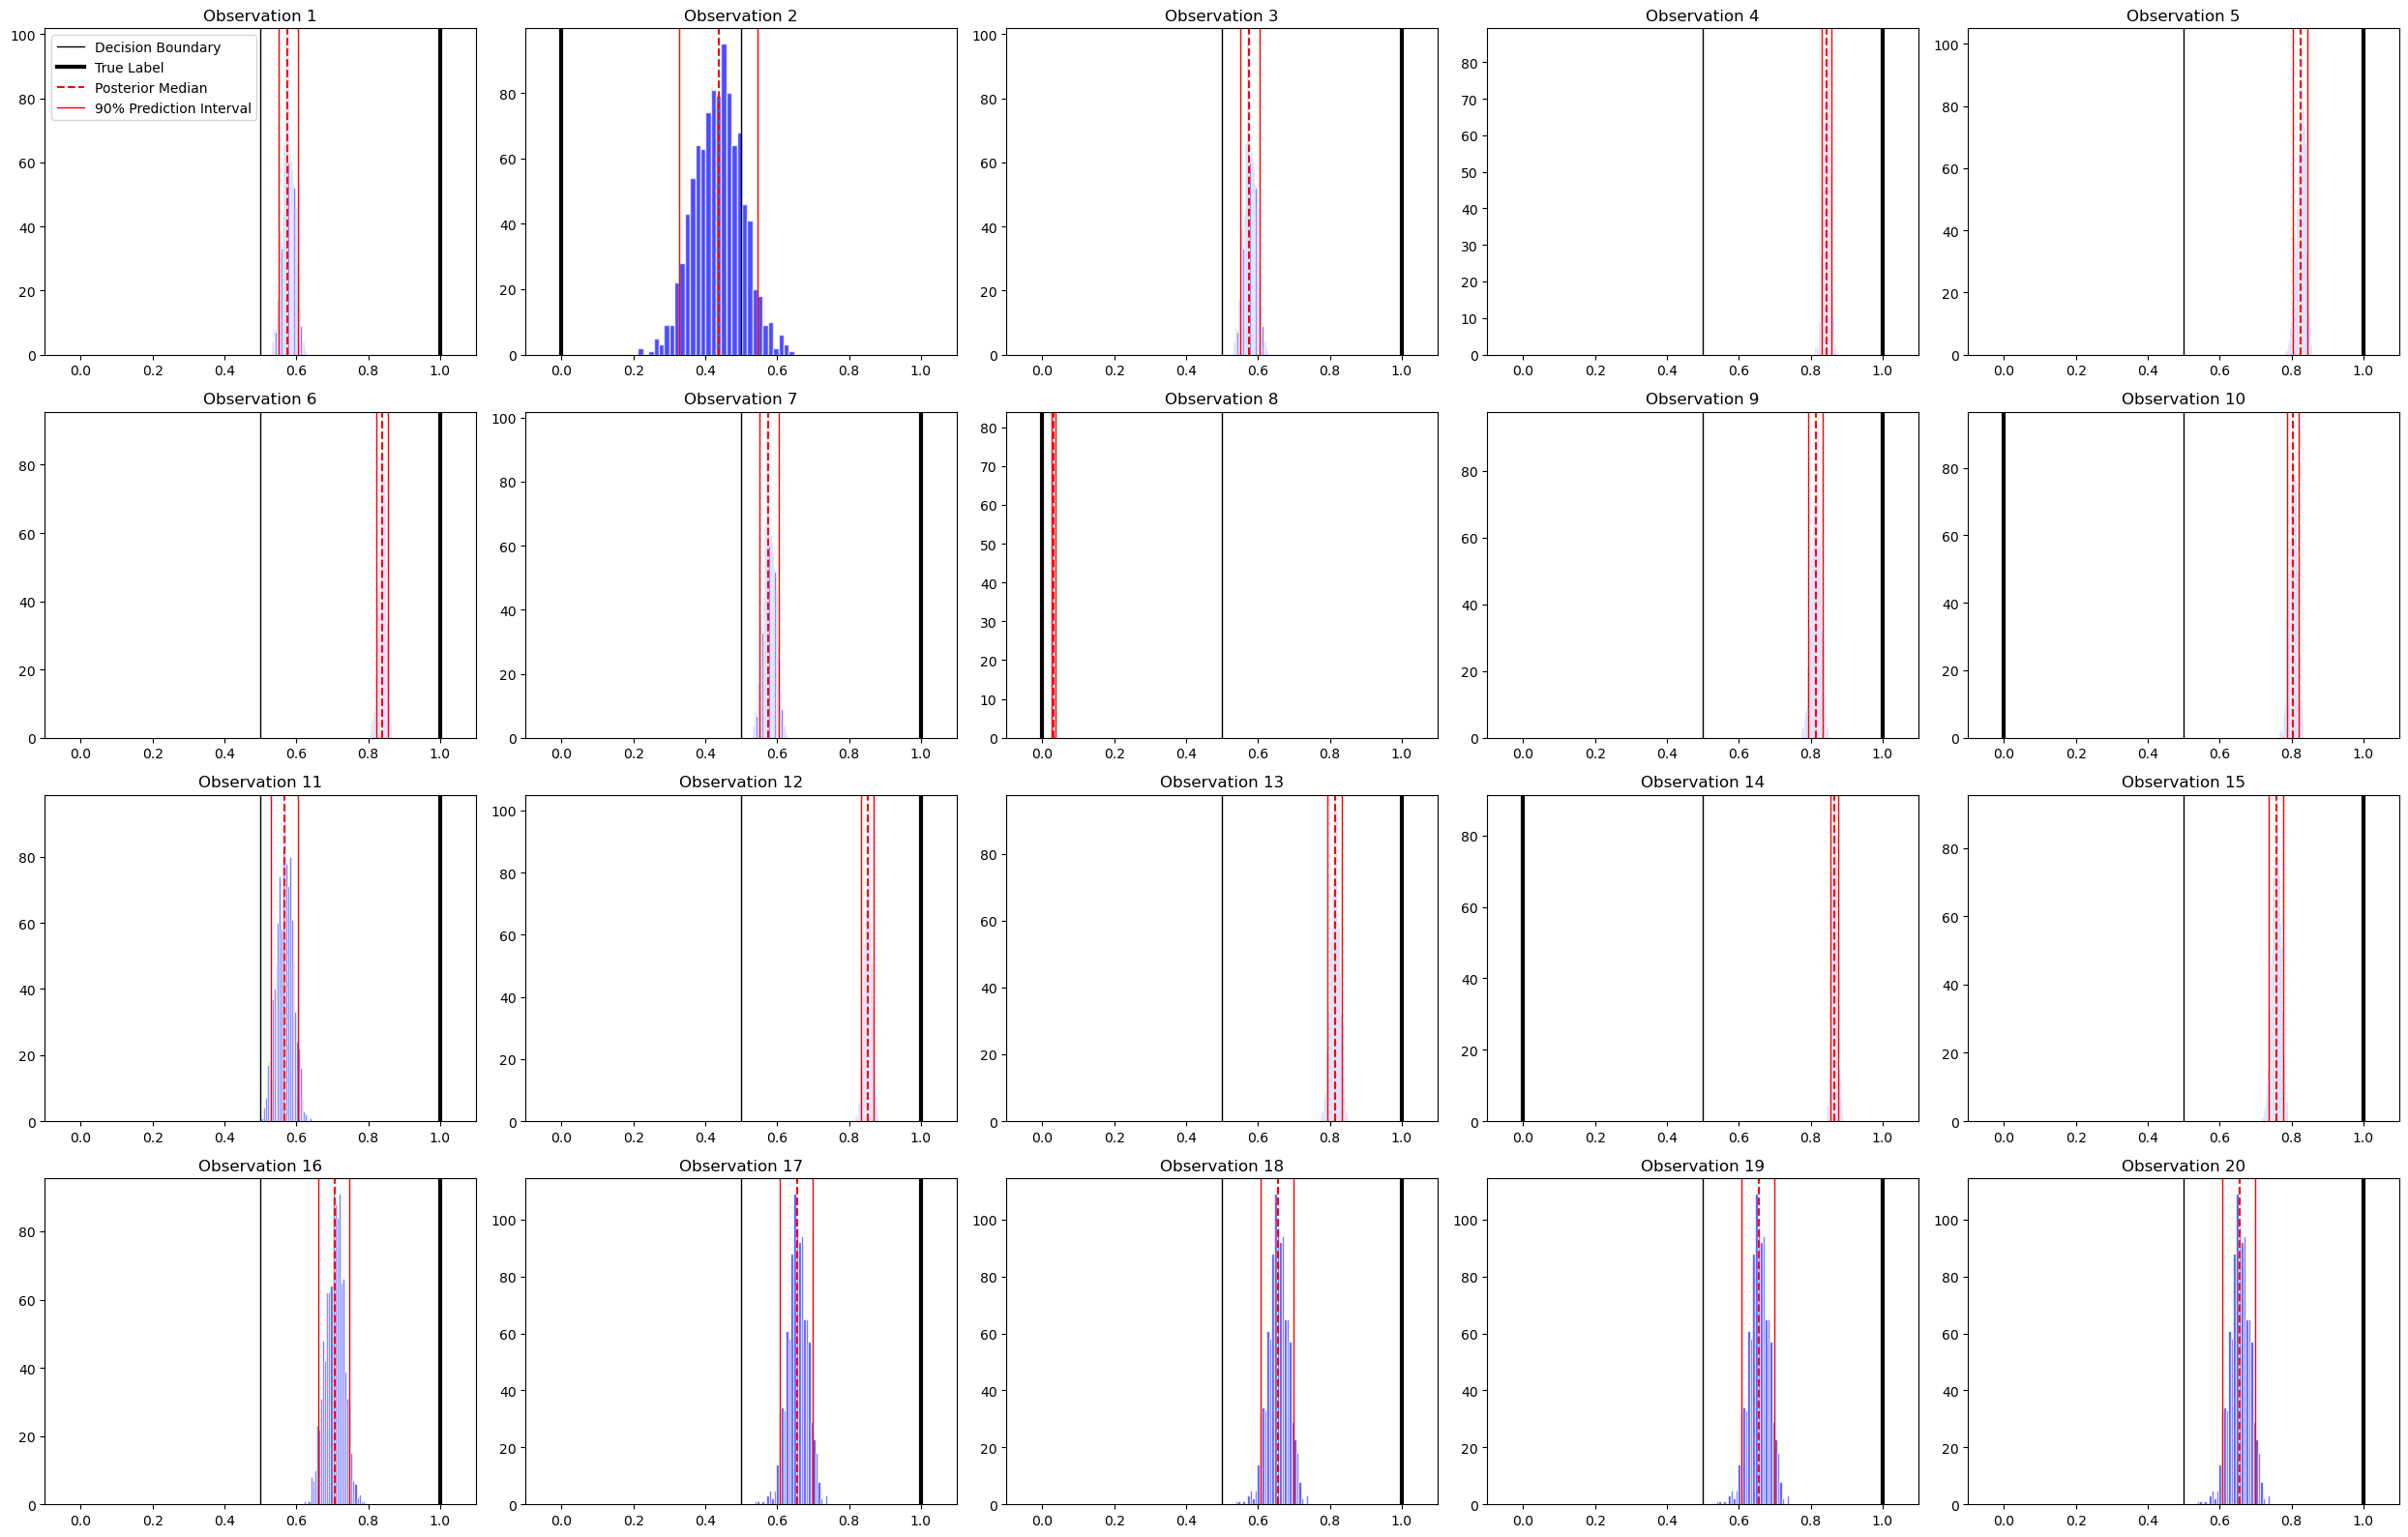

In [13]:
#Select target features
true_labels = YX_test['gname']

#Calculate the median and the 90% interval for observations
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

#Set figure size and axes
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

#Plot the postertior distribution and statistical measures for the first 20 observations
for i in range(20):
    ax = axes[i // 5, i % 5]
    #Create a histogram with predicted probabilities per observation
    ax.hist(predictions[:, i], bins=30, color='blue', edgecolor='white', alpha=0.7)
    
    #Draw a line for decision boundary, in this case it is set for 0.5 (or 50%) 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    #Draw a thick black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    #Draw line for posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    #Draw lines for the 90% prediction interval
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot which can be applied for all subplots
        ax.legend()

plt.tight_layout()
plt.show()

##### Interpretation
These plots each represent one observation, showing the posterior distribution of the probabilities predicted from the logistic regression model. With the threshold of binary classification at 0.5 (above it values=1 or Yes) the plots showed that a majority of the observations were classified as a Yes and most predicted probabilities are around 0.6 to 0.8.

In [14]:
#Simulate classified outcomes (1 or 0) from the posterior-predictive distribution 
simulated_outcomes = np.random.binomial(1, predictions)

#### Evaluate Model

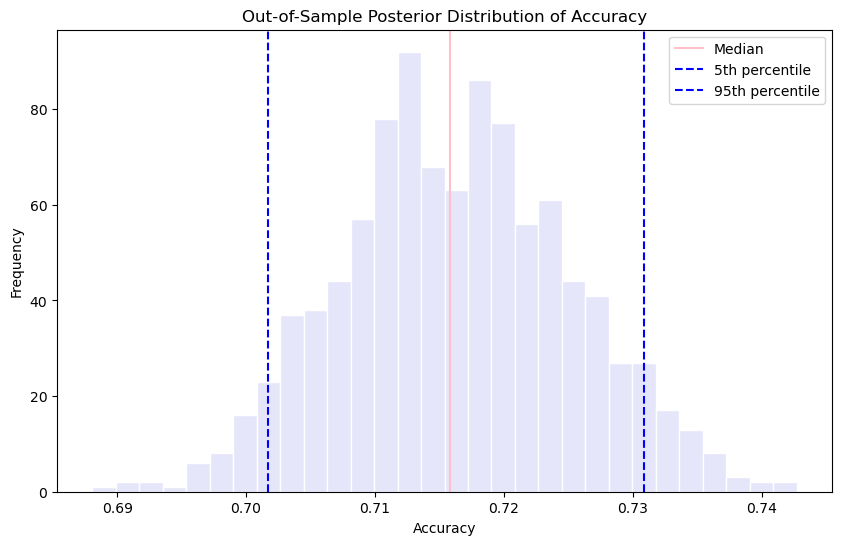

In [15]:
#Calculate accuracy for each of the 1000 simulations
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))

#Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=30, color='lavender', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='pink', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='blue', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='blue', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()

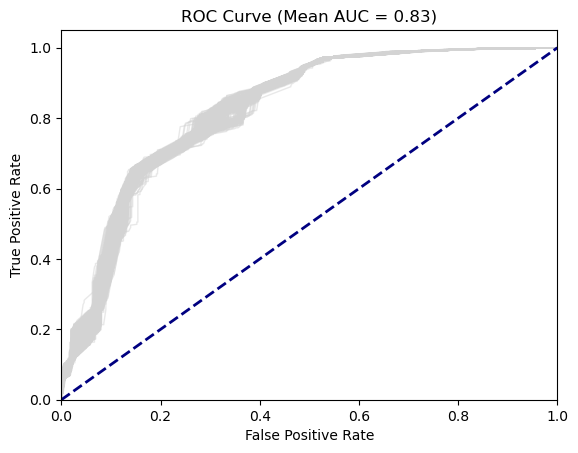

In [16]:
#Error metric: ROC curve and AUC

# Initialize lists to store TPRs (True Positive Rate), FPRs (False Positive Rare), and AUCs (Area Under the Curve) for each simulation
tprs = []
fprs = []
aucs = []

# Calculate ROC curve and AUC for each simulation
for i in range(n_simulations):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[i])
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='lightgray', lw=1, alpha=0.5)  # Plot each ROC curve faintly

# Calculate the mean AUC
mean_auc = np.mean(aucs)

# Plotting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Mean AUC = {mean_auc:.2f})')
plt.show()

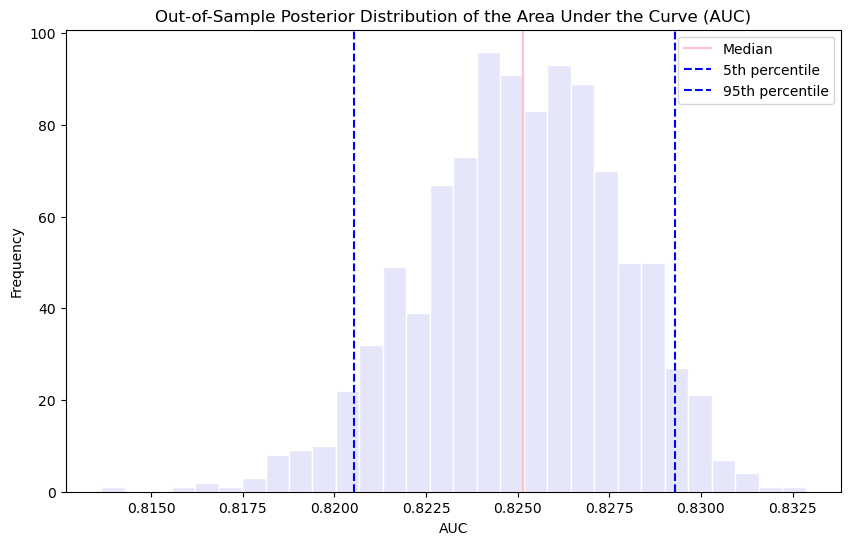

In [17]:
# Plot the histogram of AUC
plt.figure(figsize=(10, 6))
plt.hist(aucs, bins=30, color='lavender', edgecolor='white')
plt.axvline(x=np.median(aucs), color='pink', label='Median')
plt.axvline(x=np.percentile(aucs, 5), color='blue', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(aucs, 95), color='blue', linestyle='--', label='95th percentile')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of the Area Under the Curve (AUC)')
plt.legend()
plt.show()

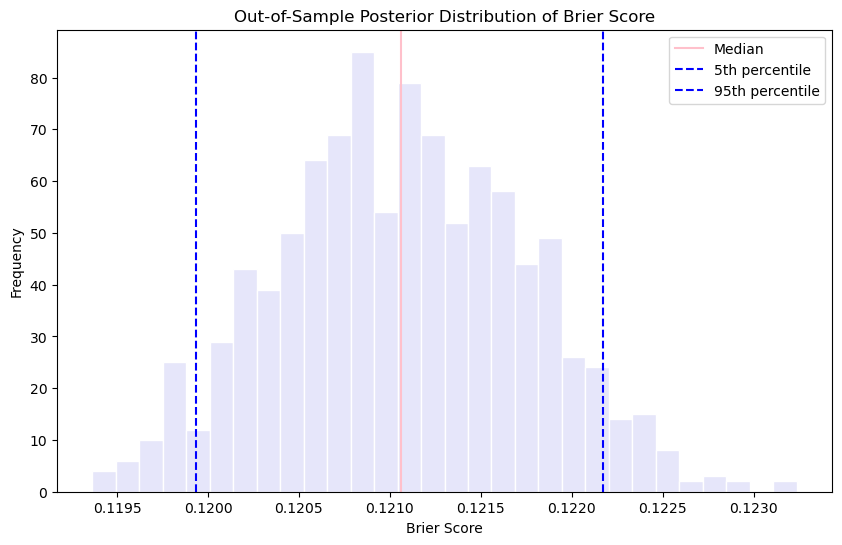

In [18]:

#Calculate Brier score for each simulation
briers = [brier_score_loss(true_labels, predictions[i]) for i in range(n_simulations)]

# Plot the histogram of Brier scores
plt.figure(figsize=(10, 6))
plt.hist(briers, bins=30, color='lavender', edgecolor='white')
plt.axvline(x=np.median(briers), color='pink', label='Median')
plt.axvline(x=np.percentile(briers, 5), color='blue', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(briers, 95), color='blue', linestyle='--', label='95th percentile')
plt.xlabel('Brier Score')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Brier Score')
plt.legend()
plt.show()

##### Interpretation
Considering the distribution of the evaluation emtrics used, it can be argued that the model is efficienty and accurately predicting both probabilities and actual classes. Accuracy, indicating how the model performs across both classes, is over 0.70 while the ROC curve and the AUC score, which focus on probabilistic prediction and discrimination of classes, are both above 0.80. The Brier score, used to evaluate the accuracy of the probabilistic predictions, is close to 0 meaning that the probabilitie match the outcomes.